In [1]:
# We will use this cell to import all the packages you will need in the following - think of it as turning on all your systems
# in your cockpit

# This makes sure that if you change code in your external scripts, they will be updated


import checker
import generator

from IPython.display import display, clear_output
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

import importlib
importlib.reload(checker)
importlib.reload(generator)

# now go ahead and Run the cell. This might take a while...
# while the cell is running, you will see ln[*] next to it. Once it finished, you will see the number of execution
# In case you want to interrupt the run of a cell, press Ctrl + C (on your german keyboard, this is Strg + C)

<module 'generator' from 'C:\\Users\\Kilian\\OneDrive\\Studium\\Bildverarbeitung\\Abgabe\\generator.py'>

In [2]:
# pip install --upgrade tensorflow
# tensorflow version 2.14.0 is used

In [3]:
# There is this joke that once you have added this import line to your code, 
# you are allowed to sell your product telling everyone that you are using AI. Life is easy, sometimes.

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
print('Tensorflow version:', tf.__version__, '(Expected 2.14.0)')



# Keras is a model-level library, meaning that it is built upon tensorflow (using it as a backend) - allowing for
# high-level building blocks. Making it even easier to design neural networks.
# We will access it as tf.keras

# The tf and k abbreviations are best practice (same for numpy np and pandas pd), 
# since you do not want to type T E N S O R F L O W all over your code.
# They are prevalent all over the industry and academia in a way that you'll risk a fight if you import them differently.

Tensorflow version: 2.14.0 (Expected 2.14.0)


In [4]:
# Set the random seed
np.random.seed(0)
tf.random.set_seed(0)

In [5]:
# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


In [6]:
# sample only 15k images for training
datas = 15000
x_train = x_train[:datas:]
y_train = y_train[:datas:]

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (15000, 28, 28)
y_train: (15000,)
x_test: (10000, 28, 28)
y_test: (10000,)


In [7]:
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255

# in the next step, we also need to reshape our input to fit our input layer later on. 
# This is due to keras expecting a definition for how many channels your input sample has, as we 
# deal with gray scale this is 1.
x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)

In [8]:
# This is the moment where you define your model's architecture

marvin = tf.keras.models.Sequential([
# input layer
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
# data augmentation
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.01),
  tf.keras.layers.experimental.preprocessing.Resizing(24, 26),
# first conv layer
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),
# second conv layer
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.2), #between 0 and 0.5
# flatten and fully connected layer
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'), # fully connected
  tf.keras.layers.Dropout(0.4), #between 0 and 0.5
# adds GaussianNoise
  tf.keras.layers.GaussianNoise(0.1),
# softmax layer
  tf.keras.layers.Dense(10, activation='softmax')
])
marvin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 28, 28, 1)         0         
 ation)                                                          
                                                                 
 resizing (Resizing)         (None, 24, 26, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 22, 24, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 12, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 11, 12, 32)        128       
 Normalization)                                                  
                                                        

In [9]:
# Define your loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


print(-tf.math.log(1/10))

sampleID = 100
loss_fn(y_train[:1], marvin(x_train[sampleID-1:sampleID]).numpy()).numpy()

tf.Tensor(2.3025851, shape=(), dtype=float32)


2.2762256

In [10]:
# Compiling basically means to prepare the training routine for your model which consists of the optimizer, 
# the loss, and the metrics which are to be reported during training

# define learningrate for adam
#tf.keras.optimizers.Adam.learning_rate=0.1

marvin.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [11]:
import datetime
import os
%load_ext tensorboard


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [12]:
# get ready for your first training run.

%time hist = marvin.fit(x_train, y_train, epochs=10, batch_size=32, shuffle=True, validation_data=(x_test, y_test))
    # callbacks=[tensorboard_callback]


marvin.evaluate(x_test, y_test)

Epoch 1/10
469/469 [==============================] - 15s 27ms/step - loss: 0.7457 - accuracy: 0.7545 - val_loss: 0.2812 - val_accuracy: 0.9618
Epoch 2/10
469/469 [==============================] - 12s 25ms/step - loss: 0.2602 - accuracy: 0.9210 - val_loss: 0.0987 - val_accuracy: 0.9712
Epoch 3/10
469/469 [==============================] - 12s 27ms/step - loss: 0.1927 - accuracy: 0.9443 - val_loss: 0.0827 - val_accuracy: 0.9751
Epoch 4/10
469/469 [==============================] - 12s 26ms/step - loss: 0.1552 - accuracy: 0.9540 - val_loss: 0.0818 - val_accuracy: 0.9757
Epoch 5/10
469/469 [==============================] - 12s 26ms/step - loss: 0.1430 - accuracy: 0.9573 - val_loss: 0.0588 - val_accuracy: 0.9804
Epoch 6/10
469/469 [==============================] - 12s 26ms/step - loss: 0.1266 - accuracy: 0.9613 - val_loss: 0.0550 - val_accuracy: 0.9823
Epoch 7/10
469/469 [==============================] - 12s 26ms/step - loss: 0.1112 - accuracy: 0.9669 - val_loss: 0.0478 - val_accuracy:

[0.047567594796419144, 0.984000027179718]

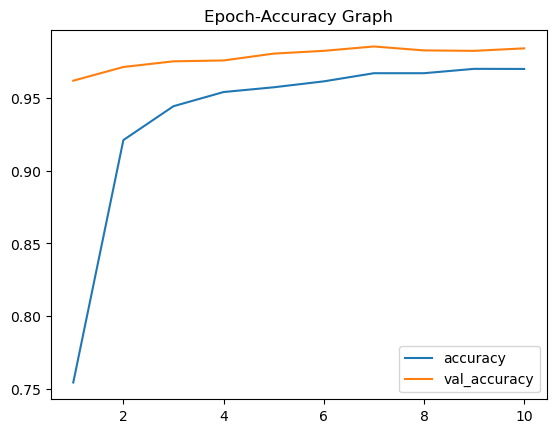

In [13]:
#Visualization Model Accuracy

plt.title('Epoch-Accuracy Graph')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.plot(range(1, len(hist.epoch) + 1), hist.history['accuracy'])
plt.plot(range(1, len(hist.epoch) + 1), hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [14]:
# This line would start up tensorboard for you
# %tensorboard --logdir logs

In [15]:
# after the training finishes, we will also save Marvin in Keras style (HDF5), so we do not have to 
# train him again
# every time we start our computer. Obviously, by changing the model_name, you can also save different
# configurations of Marvin. The name has to be a string, like this: 'name.h5'
model_name = 'marvin_lr.h5'
marvin.save(model_name, save_format='h5')

# It is best practice to indicate what configuration changes you did within the name, so you know
# which model you need to load already from its name
# Let's say instead of a learning rate of 0.001 you used 0.1, your naming could then look like:
# 'marvin_lr01.h5'

print('Success! You saved Marvin as: ', model_name)

Success! You saved Marvin as:  marvin_lr.h5


C:\Users\Kilian\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# load a saved marvin configuration you want to evaluate
model_name = 'marvin_lr.h5'
marvin_reloaded = tf.keras.models.load_model(model_name)

# Let Marvin predict on the test set, so we have some data to evaluate his performance.
predictions = marvin_reloaded.predict([x_test])

# Remember that the prediction of Marvin is a probability distribution over all ten-digit classes
# We want him to assign the digit class with the highest probability to the sample.
predictions = np.argmax(predictions, axis=1)
#pd.DataFrame(predictions)

313/313 [==============================] - 2s 7ms/step


In [17]:
(test_loss, test_acc) = marvin_reloaded.evaluate(x_test, y_test)
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

313/313 [==============================] - 3s 7ms/step - loss: 0.0476 - accuracy: 0.9840
Loss:  0.047567594796419144
Accuracy:  0.984000027179718


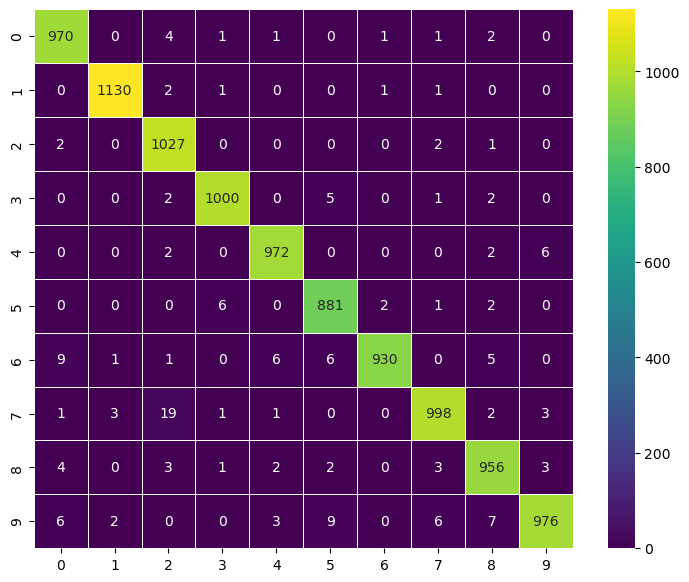

In [18]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()